In [1]:
import pandas as pd
import numpy as np
import re
import shutil
import os
import string
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.cross_validation import StratifiedKFold,  train_test_split
import statsmodels.stats.api as sms
from IPython.display import display

from build_model import EcgClassification
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import product 
def trigrams():
    tokens = []
    for token in product(string.ascii_uppercase, repeat=3):

        if token[0] > 'F':
            break

        if token[1] > 'F' or token[2] > 'F':
            continue

        tokens.append(''.join(token))
    return tokens
trs = trigrams()

In [3]:
def create_train_vw(data_all, target, file_res, file_true_labels, file_observs_train):
    n_observs = data_all.n_observ
    X_train = data_all[np.setdiff1d(data_all.columns, [target])][trs]
    y_train = data_all[target]
    
    dis_idxs = y_train[y_train == 1].index
    data = X_train.T.apply(OrderedDict)

    with open(file_true_labels + '.txt', 'w') as lab:
        with open(file_res + '.txt', 'w') as fout:
            for key, value  in zip(data.index, data):
                fout.write('{} '.format(n_observs.loc[key]))

                for tr, freq in value.items():
                    fout.write('{}:{} '.format(tr, freq))

                fout.write('|labels ')

                if key in dis_idxs:
                    fout.write('{}:{} '.format('label0', 0))
                    fout.write('{}:{}'.format(' label1', 1))
                    lab.write('1')
                else:
                    fout.write('{}:{}'.format('label0', 1))
                    fout.write('{}:{}'.format(' label1', 0))
                    lab.write('0')

                fout.write('\n')
                lab.write('\n')
    np.save(file_res + '.npy', X_train.values)
    np.save(file_true_labels + '.npy', y_train.values) 
    np.save(file_observs_train + '.npy', n_observs)
    
def create_valid_vw(data_all, target, file_res, file_true_labels):
    n_observs = data_all.n_observ
    X_valid = data_all[np.setdiff1d(data_all.columns, [target])][trs]
    y_valid = data_all[target]
    
    dis_idxs = y_valid[y_valid == 1].index
    data = X_valid[trs].T.apply(OrderedDict)

    with open(file_true_labels + '.txt', 'w') as lab:
        with open(file_res + '.txt', 'w') as fout:
            for key, value  in zip(data.index, data):
                fout.write('{} '.format(n_observs.loc[key]))

                for tr, freq in value.items():
                    fout.write('{}:{} '.format(tr, freq))

                #fout.write('|labels ')

                if key in dis_idxs:
                    lab.write('1')
                else:
                    lab.write('0')

                fout.write('\n')
                lab.write('\n')
    np.save(file_res + '.npy', X_valid.values)
    np.save(file_true_labels + '.npy', y_valid.values)

In [4]:
def reject_shuffle(idxs, n_shuffles):
    orders = set()       
    for i in range(n_shuffles):
        while tuple(idxs) in orders:
            np.random.shuffle(idxs)
        orders.add(tuple(idxs))
    for idx in orders:
        yield idx

def create_shuffled_vws(file_src, file_true_labels, file_observs_train, n_shuffles):
    with open(file_src + '.txt', 'r') as fin:
        data = fin.readlines()
    data_arr = np.load(file_src + '.npy')

    with open(file_true_labels + '.txt', 'r') as fin:
        y_true = fin.readlines()
    y_true_arr = np.load(file_true_labels + '.npy')
    n_observs = np.load(file_observs_train + '.npy')
    
    idxs = np.arange(data_arr.shape[0])
    for i, idx in enumerate(reject_shuffle(idxs, n_shuffles)):
        idx_val = np.array(idx, dtype=int)
        data_shuffle = np.array(data)[idx_val]
        y_true_shuffle = np.array(y_true)[idx_val]
        
        data_arr_shuffle = data_arr[idx_val]
        y_true_arr_shuffle = y_true_arr[idx_val]
        n_observs_shuffle = n_observs[idx_val]
    
        with open('{}{}.txt'.format(file_src, i), 'w') as fout:
            fout.write(''.join(data_shuffle))
        np.save('{}{}.npy'.format(file_src, i), data_arr_shuffle)
        
        with open('{}{}.txt'.format(file_true_labels, i), 'w') as fout:
            fout.write(''.join(y_true_shuffle))
        np.save('{}{}.npy'.format(file_true_labels, i), y_true_arr_shuffle)
        np.save('{}{}.npy'.format(file_observs_train, i), n_observs_shuffle)

In [5]:
n_dis = 69
n_diseas = np.array([95, 13, 102, 32, 96, 70, 101], dtype=int)
n_health = 1

data = pd.read_csv('data.txt', sep='\t')
data.columns = ['n_record', 'n_observ'] + list(range(1, 137))

p3 = pd.read_csv('p3.txt', sep='\t')
p3.columns  = trs

ind_health = data[n_health] == 1
ind_dis = data[n_dis] == 1

data_health = p3.loc[ind_health]
data_dis = p3.loc[ind_dis]

data_all = pd.concat([data_health, data_dis], axis=0)
data_all['n_observ'] = data.n_observ

target = 'p_chronic_cholecystitis'
data_all[target] = 0
data_all.loc[ind_dis, target]  = 1
data_all = data_all.sample(frac=1, random_state=241)

observs = data_all.n_observ.unique()
train_size = int(observs.shape[0] * 0.7) + 1
np.random.seed(241)
train_observs = np.random.choice(
                   observs,
                   train_size,
                   replace=False)

train_idxs = data_all.n_observ.isin(train_observs)
train = data_all[train_idxs]
valid = data_all[~train_idxs]

X_train = train[trs]
y_train = train[target]

X_valid = valid[trs]
y_valid = valid[target]


n_shuffles = 10
#create_train_vw(train, target, 'vw_train', 'true_labels_train', 'observs_train')
#create_valid_vw(valid, target, 'vw_valid', 'true_labels_valid')

#create_shuffled_vws('vw_train', 'true_labels_train', 'observs_train', n_shuffles)

In [84]:
def NaiveBayes(X_train, y_train, X_test, y_test, k, *args):
    #X_train_bin = (X_train >= bin_thr).astype(int)
    #X_test_bin = (X_test >= bin_thr).astype(int)
    
    p_cw = np.zeros((2, k))
    p_cw[0, :] = X_train[y_train == 0].sum(axis=0) 
    p_cw[1, :] = X_train[y_train == 1].sum(axis=0)  
    p_cw /= X_train.sum(axis=0) 
    p_cw[np.isnan(p_cw)] = 0.5
    
    probas_train = p_cw.dot(X_train.T) 
    probas_test = p_cw.dot(X_test.T) 
    
    predict_train = probas_train[1] 
    predict_train /= predict_train.max() or 1
    
    predict_test = probas_test[1] 
    predict_test /= predict_test.max() or 1

    return (roc_auc_score(y_train, predict_train),
            roc_auc_score(y_test, predict_test),
            log_loss(y_train, predict_train),
            log_loss(y_test, predict_test))

In [38]:
def sindrom_algorithm(X_train, y_train, X_test, y_test, k, bin_thr, type_weights):
    X_train_bin = (X_train >= bin_thr).astype(int)
    X_test_bin = (X_test >= bin_thr).astype(int)
    
    n_dis = np.count_nonzero(y_train)

    sort_values_dis = (X_train_bin[y_train == 1].sum(
        axis=0) + 1.0) / (n_dis + 2.0)
    sort_values_health = (X_train_bin[y_train == 0].sum(
        axis=0) + 1.0) / (y_train.shape[0] - n_dis + 2.0)

    selected_feat = np.argsort(sort_values_dis)[::-1][:k]

    if type_weights == 1:
        weights = np.log(sort_values_dis * (1 - sort_values_health)) - \
            np.log(sort_values_health * (1 - sort_values_dis))
    else:
        weights = np.mean(X_train_bin[y_train == 1], axis=0) - np.mean(X_train_bin[y_train == 0], axis=0)
        
    final_weights = np.zeros(weights.shape)
    final_weights[selected_feat] = weights[selected_feat]

    predict_train = X_train_bin.dot(final_weights.reshape(final_weights.shape[0], 1))
    predict_train /= predict_train.max() or 1
    
    predict_test = X_test_bin.dot(final_weights.reshape(final_weights.shape[0], 1))
    predict_test /= predict_test.max() or 1
    
    return (roc_auc_score(y_train, predict_train),
            roc_auc_score(y_test, predict_test),
            log_loss(y_train, predict_train),
            log_loss(y_test, predict_test))

In [37]:
def sindrom_algorithm_score(n_shuffles,
                            n_folds,
                            klist,
                            bin_thrlist,
                            type_weights):
    (mean_auc, mean_logloss) =\
                        cross_val_score(sindrom_algorithm,
                                        n_shuffles,
                                        n_folds,
                                        klist,
                                        bin_thrlist,
                                        type_weights)

    figure(figsize=(12, 7))

    xlim([min(klist), max(klist)])
    ylim([0.5, 1])
    xticks(arange(1, max(klist), 10))
    tick_params(axis='both', which='major', labelsize=10)
    xlabel('k', fontsize=18)
    ylabel('AUC', fontsize=18)
    values = []
    keys = []
    for key, value in sorted(mean_auc.items()):
        values.append(value)
        keys.append(key)
    plot(keys, values, color='magenta', lw=5)
    legend(['TrainCV'], fontsize=18, loc='best')
    savefig('auc_SA_type_weights:{}.png'.format(type_weights))
    show()

    figure(figsize=(12, 7))
    xlim([min(klist), max(klist)])
    xticks(arange(1, max(klist), 10))
    tick_params(axis='both', which='major', labelsize=10)
    xlabel('k', fontsize=18)
    ylabel('LogLoss', fontsize=18)
    values = []
    keys = []
    for key, value in sorted(mean_logloss.items()):
        values.append(value)
        keys.append(key)
    plot(keys, values, color='purple', lw=5)
    legend(['TrainCV'], fontsize=18, loc='best')
    savefig('logloss_SA_type_weights:{}.png'.format(type_weights))
    show()
    best_key = max(mean_auc, key=lambda i: mean_auc[i])
    print ('SA. Type_weights:{}. Best_param:{}'.format(type_weights, best_key))
    return best_key, mean_auc, mean_logloss

In [36]:
def cross_val_score(model, n_shuffles, n_folds, klist, bin_thrlist, *args):
    auc_folds = {}
    logloss_folds = {}
    for k in klist:
        for bin_thr in bin_thrlist:
            key = (k, bin_thr)
            auc_folds[key] = []
            logloss_folds[key] = []
        
    for n_shuffle in range(n_shuffles):
        X_train = np.load('vw_train{}.npy'.format(n_shuffle))
        y_train = np.load('true_labels_train{}.npy'.format(n_shuffle))
        n_observs = np.load('observs_train{}.npy'.format(n_shuffle))
                
        _, idx = np.unique(n_observs, return_index=True)
        y_train_observs = y_train[np.sort(idx)]
        skf = StratifiedKFold(y_train_observs, n_folds, random_state=241)
        
        for k in klist:
            for bin_thr in bin_thrlist:
                key = (k, bin_thr)
                for n_fold, (i, j) in enumerate(skf):
                    train_idx = np.in1d(n_observs, n_observs[i])
                    test_idx = np.in1d(n_observs, n_observs[j])
                    (_, auc,
                     _, logloss) =  model(X_train[train_idx],
                                          y_train[train_idx],
                                          X_train[test_idx],
                                          y_train[test_idx],
                                          k,
                                          bin_thr,
                                          args[0] if args else 0)

                    auc_folds[key].append(auc)
                    logloss_folds[key].append(logloss)
           
    mean_auc = {}
    mean_logloss = {}
    
    for key in auc_folds.keys():
        mean_auc[key] = np.mean(auc_folds[key])
        mean_logloss[key] = np.mean(logloss_folds[key])
        
    return (mean_auc, 
            mean_logloss)

In [ ]:
scores = {}
n_shuffles = 10
n_folds = 10
klist = [65]
bin_thrlist = [2]
type_weights = 1

best_key, mean_auc, mean_logloss = \
                sindrom_algorithm_score(n_shuffles, n_folds, klist, bin_thrlist, type_weights)
scores['SA_type_weights:{}'.format(type_weights)]  = \
        OrderedDict([             
           ('AUC(TrainCV)', mean_auc[best_key]), 
           ('LogLoss(TrainCV)', mean_logloss[best_key])])
    
type_weights = 2

best_key, mean_auc, mean_logloss = \
                sindrom_algorithm_score(n_shuffles, n_folds, klist, bin_thrlist, type_weights)
scores['SA_type_weights:{}'.format(type_weights)]  = \
        OrderedDict([             
           ('AUC(TrainCV)', mean_auc[best_key]), 
           ('LogLoss(TrainCV)', mean_logloss[best_key])])
    
klist = [216]
bin_thrlist = [2]

(mean_auc, mean_logloss) = \
              cross_val_score(NaiveBayes, n_shuffles, n_folds, klist, bin_thrlist)
    
scores['NB']  = OrderedDict([             
    ('AUC(TrainCV)', list(mean_auc.values())[0]),
    ('LogLoss(TrainCV)', list(mean_logloss.values())[0])])

In [ ]:
X_train_val = X_train.values
y_train_val = y_train.values

X_valid_val = X_valid.values
y_valid_val = y_valid.values

type_weights = 1
best_key = (134, 2)
(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = sindrom_algorithm(X_train_val,
                                    y_train_val,
                                    X_valid_val,
                                    y_valid_val,
                                    best_key[0],
                                    best_key[1], 
                                    type_weights)


scores['SA_type_weights:1']['AUC(Valid)'] =  auc_valid
scores['SA_type_weights:1']['LogLoss(Valid)'] =  logloss_valid

type_weights = 2
best_key = (135, 2)
(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = sindrom_algorithm(X_train_val,
                                    y_train_val,
                                    X_valid_val,
                                    y_valid_val,
                                    best_key[0],
                                    best_key[1], 
                                    type_weights)


scores['SA_type_weights:2']['AUC(Valid)'] =  auc_valid
scores['SA_type_weights:2']['LogLoss(Valid)'] =  logloss_valid


(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = NaiveBayes(X_train_val,
                             y_train_val,
                             X_valid_val,
                             y_valid_val,
                             216,
                             2)

scores['NB']['AUC(Valid)'] =  auc_valid
scores['NB']['LogLoss(Valid)'] =  logloss_valid

In [13]:
data_dir = 'data_ekg'
shutil.rmtree(data_dir)

In [30]:
data_dir = 'data_ekg'
n_objs = 548
n_topics = 8
n_topics_health = 1
n_collection_passes = 25
n_document_passes = 1
n_shuffles = 1
n_folds = 10
clf = EcgClassification(data_dir, 
                        n_objs,
                        n_topics,
                        n_topics_health,
                        n_collection_passes, 
                        n_document_passes,
                        n_shuffles,
                        n_folds)

#tau = np.hstack((np.repeat([1e2, 1e2 * 5], [5, 5]), np.repeat([1e3, 1e3 * 5], [5, 5]), np.repeat([1e4], [5])))
tau = np.repeat([1e2, 1e3, 1e4], [10, 8, 7])
tau_phi_gram3 = np.hstack((np.hstack(([0] * 5, np.linspace(-1e2, -1e2, 15))), [-1e2] * 5)) 
w_gram3   = [1] * n_collection_passes

(auc_folds_iter, 
 logloss_folds_iter,  
 sparsity_phi_c_folds_iter, 
 sparsity_phi_gram3_folds_iter,
 sparsity_theta_folds_iter,
 ptc) =  clf.cross_val_score(tau, w_gram3, tau_phi_gram3)

/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


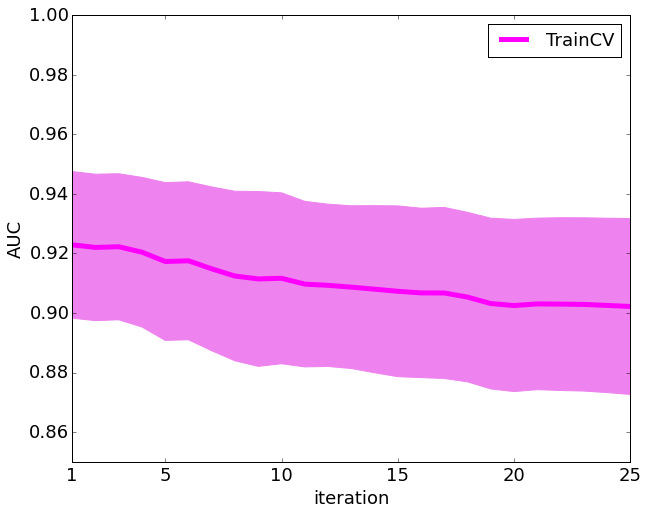

In [24]:
figure(figsize=(10, 8))

left_edge = []
right_edge = []
mean_auc = []
iters = []
for key, value in auc_folds_iter.items():
    left, right = sms.DescrStatsW(value).tconfint_mean()
    left_edge.append(left)
    right_edge.append(right)
    iters.append(key + 1)
    mean_auc.append(np.mean(value))


fill_between(iters, left_edge, right_edge, color='violet')
plot(iters, mean_auc, color='magenta', lw=5)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])
ylim([0.85, 1.0])
xticks(list(xticks()[0][1:]) + [1])
tick_params(axis='both', which='major', labelsize=18)

ylabel('AUC', fontsize=18)
legend(['TrainCV'], fontsize=18, loc='best')
#savefig('auc.png')
show()

/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


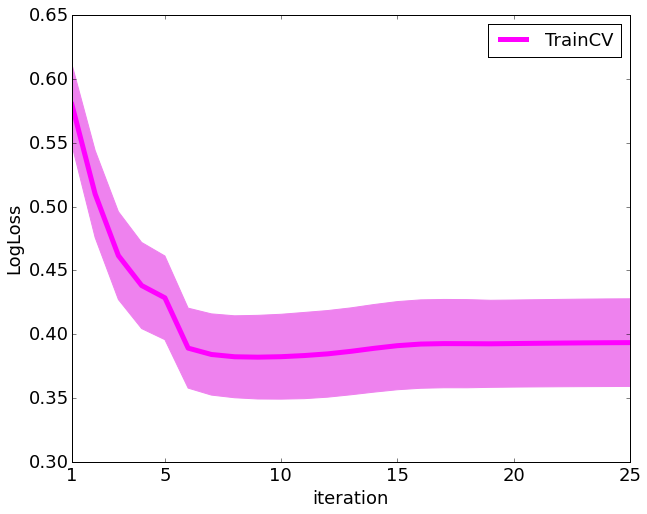

In [16]:
figure(figsize=(10, 8))

left_edge = []
right_edge = []
mean_logloss = []
iters = []
for key, value in logloss_folds_iter.items():
    left, right = sms.DescrStatsW(value).tconfint_mean()
    left_edge.append(left)
    right_edge.append(right)
    iters.append(key + 1)
    mean_logloss.append(np.mean(value))


fill_between(iters, left_edge, right_edge, color='violet')
plot(iters, mean_logloss, color='magenta', lw=5)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])
xticks(list(xticks()[0][1:]) + [1])

ylabel('LogLoss', fontsize=18)
legend(['TrainCV'], fontsize=18, loc='best')
tick_params(axis='both', which='major', labelsize=18)
#savefig('logloss.png')
show()

In [40]:
mean_sparsity_theta = []
for key, value in sparsity_theta_folds_iter.items():
    mean_sparsity_theta.append(np.mean(value))

/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Populating the interactive namespace from numpy and matplotlib


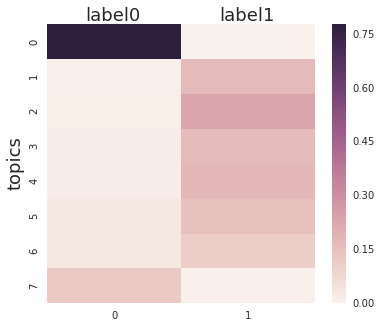

In [50]:
import seaborn as sns
%pylab inline
figure(figsize=(6, 5))
#p_tc = pd.read_csv('p_tc_topics2_tau1_10000.csv', index_col=0)
sns.heatmap(pd.DataFrame(ptc).values)
ylabel('topics', fontsize=18)
text(0.3, 8.1, 'label0', fontsize=18)
text(1.3, 8.1, 'label1', fontsize=18)
#text(0.0001, 1.5, '$label0$', fontsize=18, rotation='vertical')
#title('p(t|c)', fontsize=20)
savefig('ptc_t8.eps', format = 'eps')
show()

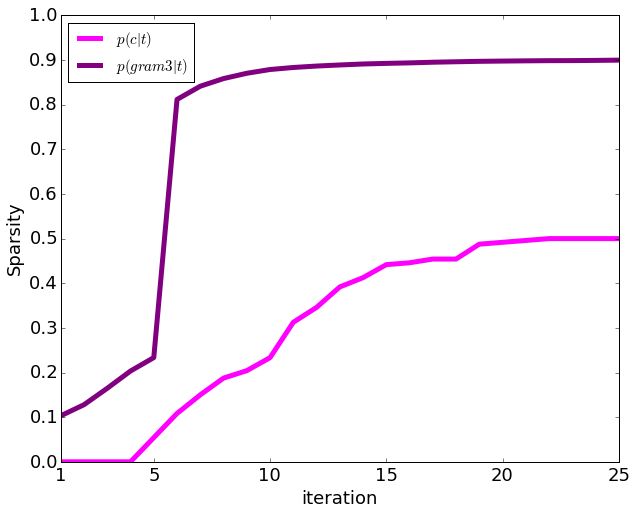

In [17]:
figure(figsize=(10, 8))

iters = []
mean_sparsity_phi_c = []
mean_sparsity_phi_gram3 = []

for key, value in sparsity_phi_c_folds_iter.items():
    iters.append(key + 1)
    mean_sparsity_phi_c.append(np.mean(value))
    
for key, value in sparsity_phi_gram3_folds_iter.items():
    mean_sparsity_phi_gram3.append(np.mean(value))

plot(iters, mean_sparsity_phi_c, color='magenta', lw=5)
plot(iters, mean_sparsity_phi_gram3, color='purple', lw=5)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])

xticks(list(xticks()[0][1:]) + [1])
yticks(np.arange(0.0, 1.1, 0.1))
tick_params(axis='both', which='major', labelsize=18)
ylabel('Sparsity', fontsize=18)
legend([r'$p(c|t)$', r'$p(gram3|t)$'], loc = 'best', fontsize = 15)
#savefig('sparsity.png')
show()

In [80]:
shutil.rmtree(data_dir)

In [79]:
data_dir = 'data_ekg'
n_objs = 548
n_topics = 8
n_topics_health = 1
n_collection_passes = 25
n_document_passes = 1
n_shuffles = 10
n_folds = 10
clf = EcgClassification(data_dir, 
                        n_objs,
                        n_topics,
                        n_topics_health,
                        n_collection_passes, 
                        n_document_passes,
                        n_shuffles,
                        n_folds)

#tau = np.hstack((np.repeat([1e2, 1e2 * 5], [5, 5]), np.repeat([1e3, 1e3 * 5], [5, 5]), np.repeat([1e4], [5])))
tau = np.repeat([1e2, 1e3, 1e4], [10, 8, 7])
tau_phi_gram3 = np.hstack((np.hstack(([0] * 5, np.linspace(-1e2, -1e2, 15))), [-1e2] * 5)) 
w_gram3   = [1] * n_collection_passes

In [81]:
os.mkdir(data_dir)
shutil.copy('true_labels_train.txt', os.path.join(data_dir, 'true_labels_train.txt'))
shutil.copy('true_labels_valid.txt', os.path.join(data_dir, 'true_labels_test.txt'))
shutil.copy('vw_train.txt', os.path.join(data_dir, 'train.txt'))
shutil.copy('vw_valid.txt', os.path.join(data_dir, 'test.txt'))
shutil.copy('vw_train.npy', os.path.join(data_dir, 'train.npy'))
shutil.copy('true_labels_train.npy', os.path.join(data_dir, 'true_labels_train.npy'))
(_, auc_valid, 
 _, logloss_valid,
 sparsity_phi_c,
 sparsity_phi_gram3,
 sparsity_theta,
 p_tc) = clf.valid_score(
                    data_dir,
                    'true_labels_train.txt',
                    'true_labels_test.txt',
                     tau,
                     w_gram3,
                     tau_phi_gram3,
)

In [ ]:
scores['ARTM']  = OrderedDict([             
    ('AUC(TrainCV)', mean_auc[-1]),
    ('LogLoss(TrainCV)', mean_logloss[-1])])

os.mkdir(data_dir)
shutil.copy('true_labels_train.txt', os.path.join(data_dir, 'true_labels_train.txt'))
shutil.copy('true_labels_valid.txt', os.path.join(data_dir, 'true_labels_test.txt'))
shutil.copy('vw_train.txt', os.path.join(data_dir, 'train.txt'))
shutil.copy('vw_valid.txt', os.path.join(data_dir, 'test.txt'))
(_, auc_valid, 
 _, logloss_valid,
 sparsity_phi_c,
 sparsity_phi_gram3,
 p_tc) = clf.valid_score(
                    data_dir,
                    'true_labels_train.txt',
                    'true_labels_test.txt',
                     tau,
                     w_gram3,
                     tau_phi_gram3)

#scores['ARTM']['AUC(Valid)'] =  auc_valid[-1]
#scores['ARTM']['LogLoss(Valid)'] =  logloss_valid[-1]
shutil.rmtree(data_dir)

In [26]:
df.to_csv('models.csv', index_col=0)